@author Joubert Alexandrino de Souza
@version 2021-02-25

-----------------------------------------------
# Heurística para escolher o melhor valor de cada característica
-----------------------------------------------

## Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

In [1]:
# Importa as bibliotecas necessárias
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn.datasets import load_iris
from collections import Counter
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Ajustes
%matplotlib inline

In [2]:
# Carrega o banco de dados Iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target
X.shape, y.shape

((150, 2), (150,))

In [3]:
# Função auxiliar
def plotDecisao(modelo, X, y):
    
    modelo.fit(X, y)

    x0s = np.linspace(np.min(X[:,0]) - 0.2,np.max(X[:,0])+0.2, 200)
    x1s = np.linspace(np.min(X[:,1]) - 0.2,np.max(X[:,1])+0.2, 200)

    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:, 1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")

    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

A Heurística construída se seleciona a melhor característica baseada no menor desvio padrão de seus dados. Considerenado que o desvio padrão mede a o quanto um conjunto de dados é uniforme, optou-se por usar essa medida na seleção de um dada característica para se tentar maximizar a ocorrência de uma classe no atributo alvo (target) e, assim, facilitar o trabalho de indução do algoritmo. Para a escolha de um valor de referência para a característica escolhida, foi usada a mediana da característica para gerar dois conjuntos distintos do atributo alvo: os maiores que a mediana e os menores. Assim, selecionou-se a média do conjunto de dados que continha mais classes.

In [4]:
# Escolhe a melhor caracteristica baseado no seu desvio padrão
def melhorCaracteristica(X, y):
    
    # Cria um vetor vazio para armazenar os desvios padrão das características 
    desvios = np.empty((X.shape[1]))

    # Calcula o desvio padrão para as características
    for caracteristica in range(X.shape[1]):
        desvios[caracteristica] = np.std(X[:, caracteristica])    

    # Escolhe o atributo com o menor desvio padrão
    melhor_caracteristica = np.argmin(desvios) 

    # Escolhe o valor do meio para a característica pela mediana
    valor_meio = np.median(X[:,])

    # Divide as características em duas porções
    maiores = X[:, melhor_caracteristica] > valor_meio
    particao_maiores = X[maiores, melhor_caracteristica]
    particao_menores = X[~maiores, melhor_caracteristica]

    # Verifica qual partição tem o maior número de classes
    tamanho1 = len(Counter(y[maiores].flat).most_common())
    tamanho2 = len(Counter(y[~maiores].flat).most_common())    

    # Seleciona a partição que contém o maior número de classes e calcula sua média
    if (tamanho1 > tamanho2):
        valor = np.mean(particao_maiores)
    else:
        valor = np.mean(particao_menores)    
    
    return melhor_caracteristica, valor

In [5]:
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]


class Arvore(BaseEstimator, ClassifierMixin):
    
        
    def fit(self, X, y):

        self.caracteristica, self.valor = melhorCaracteristica(X, y)
        
        maiores = X[:,self.caracteristica] > self.valor
        
        if sum(maiores) > 0 and sum(~maiores)>0:
            self.maiores = Arvore()            
            self.maiores.fit(X[maiores, :], y[maiores])
            
            self.menores = Arvore()            
            self.menores.fit(X[~maiores], y[~maiores])
        else:
            mais = maisFrequente(y)            
            self.resposta = mais          
        
    def predict(self, X):
        
        y = np.empty((X.shape[0]))        

        if hasattr(self, 'resposta'):            
            y[:] = self.resposta

        else:            
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])        
        return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
print("Acurácia: ", accuracy_score(y, ypred))

Acurácia:  0.96


## Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos. 

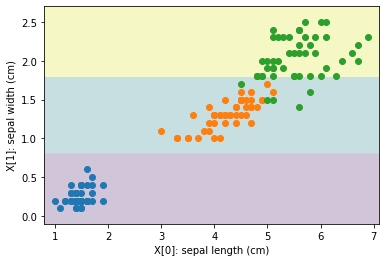

In [6]:
plotDecisao(modelo, X, y)

A heurística acima conseguiu uma acurária de 96% com resubstituição. Pela analise gráfica verifica-se  poucos erros na predição, cerca de 5. Isso mostra que o modelo está superajustado aos dados e, portanto, teria pouca capacidade de generalização. 

Contrapondo esta heurística com àquela proposta nos vídeos, que conseguiu uma acurária de 95% também com resubstituição, podemos concluir que os algorimos são próximos. 

Uma dirença visível se dá pela escolha da característica a qual sempre é escolhida a característica 0 (Sepal Width) para o exemplo dos vídeos e sempre a característica 1 (Sepal Length) para a heurística desse trabalho. 

Porém, a heurística proposta por esse autor certamente é mais "ingênua" do que a heurística proposta nos vídeos, pois, não apresenta uma medida de impureza de qualidade.

## Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.


### Base de dados 1

URL: https://www.kaggle.com/abineshkumark/carsdata

Informações: 
Cars Data has Information about 3 brands/make of cars. Namely US (0), Europe (1), Japan (2). Target of the data set to find the brand of a car using the parameters such as horsepower, Cubic inches, Make year, etc.

A decision tree can be used create a predictive data model to predict the car brand.


In [7]:
# Carrega o dataset
ds1 = np.loadtxt("https://raw.githubusercontent.com/joubert-alexandrino/reconhecimento-padroes/main/cars.csv", delimiter=',')

ds1.shape

(256, 8)

In [8]:
# Separa as características de predição e alvo
# A última coluna é o alvo
X, y = ds1[0:, 0:-1], ds1[:, -1]
X.shape, y.shape

((256, 7), (256,))

In [9]:
# Realiza os testes com validação cruzada
scores = cross_validate(modelo, X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.71153846, 0.64705882, 0.62745098, 0.60784314, 0.64705882]),
 0.6481900452488688)

### Base de dados 2

URL: https://www.kaggle.com/itsmesunil/bank-loan-modelling

Informações:
This case is about a bank (Thera Bank) which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.

The department wants to build a model that will help them identify the potential customers who have a higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign. 

In [10]:
ds2 = pd.read_excel('https://github.com/joubert-alexandrino/reconhecimento-padroes/raw/main/bank-personal-loan.xlsx', sheet_name=1)

ds2.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [11]:
ds2.shape

(5000, 14)

In [12]:
# Verifica se existem dados nulos
ds2.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [13]:
# Exclui as características não necessárias
ds3 = ds2.drop(['ID', 'ZIP Code'], axis=1, inplace=False)

# Separa o conjunto de características do target
X, y = ds3.drop(['Personal Loan'], axis=1, inplace=False).values.astype('float'), ds3['Personal Loan'].values.astype('float')

X.shape, y.shape

((5000, 11), (5000,))

In [14]:
# Realiza os testes
scores = cross_validate(modelo, X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.904, 0.904, 0.904, 0.904, 0.904]), 0.9040000000000001)

### Base de dados 3

URL: https://www.kaggle.com/khushboosrivastava2/gender-voice-predictiondecision-tree-modeling

Informações: Esta é uma base de dados para classificação de vozes masculinas e femininas

In [15]:
ds4 = pd.read_csv('https://raw.githubusercontent.com/joubert-alexandrino/reconhecimento-padroes/main/voice.csv', sep=',')

ds4.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [16]:
ds4.shape

(3168, 21)

In [17]:
# Verifica se existem dados nulos
ds4.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

In [18]:
# Separa o conjunto de características do target
X, y = ds4.drop(['label'], axis=1, inplace=False).values.astype(float), ds4.label.map({'male':float(1), 'female':float(2)}).values.astype(float)

X.shape, y.shape

((3168, 20), (3168,))

In [19]:
# Realiza os testes
scores = cross_validate(modelo, X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.64511041, 0.71293375, 0.81230284, 0.82622433, 0.73933649]),
 0.7471815649279132)

## Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

A título introdutório é importante registrar o tamanho das três bases escolhidas: base1 256 amostras, base2 5000 amostras e base3 3168 amostras. As acurácias médias encontradas após o processo de validação cruzada foram de aproximadamente 64,81% para a base1, 90,40% para a base2 e 74,71%. Mesmo fazendo-se uso dessa técnica, os resultados tenderam a um superajustamento que se mostrou proporcional ao tamanho de conjunto de dados usado. Tal fato pode estar diretamente relacionado com a heurística extremanente "ingênua" que foi proposta. Outro fator que pode ter influênciado nesse superajustamento é fato de não ter sido realizado nenhum tipo de tratamento dos dados como, por exemplo, o modificação da escala dos mesmos e a exclusão de características não necessárias ou irrelevante para o estudo dos fenômenos. Por fim, os resultados obtidos também podem ter sido potencializados pelo uso de todas as características dos conjuntos de dados.

